# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# magic word for producing visualizations in notebook
%matplotlib inline


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# Dump the azdias dataframe to a pickle object 
#pickle.dump(azdias, open("azdias.pickle", "wb"))

In [ ]:
# Reload azdias object 
azdias = pickle.load(open("azdias.pickle", "rb"))

In [ ]:
azdias.head()

In [ ]:
#from helpers import save_csv
#helpers.save_csv(azdias, 'data_project', 'Udacity_AZDIAS_052018.csv')
#helpers.save_csv(customers, 'data_project', 'Udacity_CUSTOMERS_052018.csv')


## Part 0.1 Data exploration 

In [ ]:
#azdias = pd.read_csv('./data_project/Udacity_AZDIAS_052018.csv')
#azdias.drop(['Unnamed: 0'], axis = 1, inplace = True)
#azdias.head()

In [ ]:
#customers = pd.read_csv('./data_project/Udacity_CUSTOMERS_052018.csv')
#customers.head()

In [ ]:
print('Describe Customers :\n')
display(customers.describe())

print('Describe Population :\n')
display(azdias.describe())

In [ ]:
# The shape of dataframes
print('Shape of azdias dataframe: {}\n'.format(azdias.shape))
print('Shape of customers dataframe: {}\n'.format(customers.shape))

#### check if azdias contains all columns in customers

In [ ]:
# check if azdias contains all columns in customers

customers_columns_list = list(customers.columns)
azdias_columns_list = list(azdias.columns)

result =  all(elem in customers_columns_list  for elem in azdias_columns_list)
 
if result:
    print("Yes, customers dataframe contains all columns in azdias dataframe")    
else :
    print("No, customers dataframe does not contain all columns in azdias dataframe")

#### Data_info and Mising values

Now we will explore a little deeper the data. Let's load the data_info.csv file so that we will have more information about the columns. This would help us in our data cleaning processing.

In [ ]:
data_info = pd.read_csv('data_info.csv')
data_info.drop(['Attribute','ISBLANK'], axis = 1, inplace = True)
data_info.rename(columns={"Attribute.1": "Attribute", "Missing_value": "Missing_Value"}, inplace = True)

data_info.head(10)

In [ ]:
missing_code_df = missing_code_df(data_info)

In [ ]:
len(data_info.Attribute.unique())

In [ ]:
# Unique code for missing values
data_info.Missing_Value.unique()

## Part 1: Data Cleaning and Data Engineering

### Part 1.1  Check for Missing Values  - azdias df 

We can notice that we have 273 columns with missing data. We can also see below that even before the missing data mapping process, we have few columns with high percentage of missing values, such as ALTER_KIND4 (99.86%), ALTER_KIND3 (99.31%), ALTER_KIND2 (96.69%),ALTER_KIND1 (90.90%), EXTSEL992(73.40%), KK_KUNDENTYP (65.60%).



In [ ]:
# columns with missing values
missing_data = azdias.isnull().sum()[azdias.isnull().sum() !=0]

# dictionary with missing values and their respective percentage 

total_rows = azdias.shape[0]
missing_dict = {'Missing_Count': missing_data.values, 
                'Percentage': np.round(missing_data.values*100/(total_rows),2)}


#Create DataFrame
azdias_missing_initial = pd.DataFrame(missing_dict, index = missing_data.index)
azdias_missing_initial.sort_values(by = 'Missing_Count', ascending = False, inplace = True)
print('Number of columns with missing values: ', azdias_missing_initial.shape[0])
display('     azdias_missing_initial DataFrame: ')
azdias_missing_initial


In [ ]:
# Double-check
print('Percentage of missing values (ALTER_KIND4): ', round(100*azdias.isnull().sum()['ALTER_KIND4']/ total_rows,2))
print('Percentage of missing values (ALTERSKATEGORIE_FEIN): ',round(100*azdias.isnull().sum()['ALTERSKATEGORIE_FEIN']/ total_rows,2))

### Part 1.2 Create dataframe with attributes and the missing codes from data_info.csv file : 

In [ ]:
#missing_code_df = data_info.drop(['Description','Value','Meaning'], axis = 1)
#missing_code_df.set_index('Attribute', inplace = True)
#missing_code_df['Missing_value'] = missing_code_df['Missing_value'].str.replace('[','').replace(']','').split(',').values

display('Missing codes and dtype: ',missing_code_df.Missing_Value.unique())
print()
missing_code_df.head()

In [ ]:
len(missing_code_df.Attribute.unique())

In [ ]:

missing_code_df.drop_duplicates(keep='first',inplace=True) 
display(len(missing_code_df.Attribute.unique()))

missing_code_df.head()

In [ ]:
len(missing_code_df.Attribute)

In [ ]:
missing_code_df.isnull().sum()

In [ ]:
# Some variables are not categorical, and have no missing value code
# let's give them a -1 code so that we can use the built in function eval() to build our dictionary with int codes
missing_code_df.fillna('[-1]', inplace = True)

In [ ]:
# Create a dictionary with attribute as key and its respective missing code as value
from helpers import create_missing_code_dict
missing_dict = create_missing_code_dict(missing_code_df)
#missing_dict   

I noticed that there are attributes in the azdias dataframe that are missing in the data_info dataframe. To be more specific, we have  93 missing Attributes and because of that we don't have information regarding their missing code.So, I will only consider nan as missing value for those attributes( I could try to consider 0 as missing value but I have no information regarding those features) 

In [ ]:
missing_column_count =0
present_column_count = 0
missing_column_list = []

for col in azdias.columns[1:]:
    if col not in missing_dict:
        missing_column_list.append(col)
        missing_column_count += 1
        pass
    else:
        present_column_count +=1
print('Number of columns of azdias df that are missing in data_info df: ', missing_column_count)
print('Number of columns of azdias df contained in data_info df: ', present_column_count)

In [ ]:
# Calculate number missing columns that have 0 (potencial missing value)
# NOTE : I am not considering 0 as missing value. This is just a test
zero_one_missing_code = []
for col in missing_column_list:
   # for val in azdias[col].value_counts().index:
        if 0 in azdias[col].value_counts().index:
           zero_one_missing_code.append(col)
print('Number of columns that contains 0: ',len(zero_one_missing_code))       

In [ ]:
from helpers import valid_values_dict
valid_values_dict = valid_values_dict(azdias, missing_dict)

 We can see below that the missing codes in the azdias dataframe has been converted to nan values.

In [ ]:
# Dataframe with missing codes converted to nan
#azdias_after_encoding = azdias.copy()


# skip LNR column
for col in azdias.columns[1:]:  

    #azdias_after_encoding[col] = azdias_after_encoding[col].map(valid_values_dict[col])
    azdias[col] = azdias[col].map(valid_values_dict[col])

#azdias_after_encoding.head()
azdias.head()

In [ ]:
azdias.head()

In [ ]:
# total of missing values per columns after converting codes
total_nan_after_encoding = azdias_after_encoding.isnull().sum()
# total of missing values per columns before converting codes
total_nan_before_encoding = azdias.isnull().sum()

#difference

diff = total_nan_after_encoding - total_nan_before_encoding

#

In [ ]:
print('Missing values before encoding:', total_nan_before_encoding.sum())
print('Missing values after encoding:', total_nan_after_encoding.sum())
print('Total increase after encoding:', diff.sum())

From now on we can work on the new dataframe.

In [ ]:
# Dump the azdias_after_encoding dataframe to a pickle object since it takes up so much room in memory.
#pickle.dump(azdias_after_encoding, open("azdias_after_encoding.pickle", "wb"))

### 1.3 Analysing Missing values

In [ ]:
#azdias_after_encoding  = pickle.load(open("azdias_after_encoding.pickle", "rb"))

In [ ]:
missing_dict = {'Before_Encoding': total_nan_before_encoding[1:],
               'After_Enconding': total_nan_after_encoding[1:],
               'Difference':diff[1:], 
               'Percent_nan': 100* total_nan_after_encoding/ azdias.shape[0]}

missing_df = pd.DataFrame(missing_dict)
missing_df.head(10)

In [ ]:
from helpers import missing_values_barplt
missing_values_barplt(missing_df,'Before_Encoding')

In [ ]:
missing_values_barplt(missing_df,'After_Enconding')


In [ ]:
missing_values_barplt(missing_df,'Difference')

In [ ]:
from helpers import missing_values_barplt
missing_values_barplt(missing_df,'Percent_nan')

The bar plots above show us that there are attributes with a lot of missing values after converting the missing value codes to nan variables. It's important to notice that some columns got a significant increase in missing values. Besides, the column AGER_TYP that has no missing values before the encoding, got tons of nan variables.

I will now check the distribution of the some attributes in order to find potencial outliers.


In [ ]:
missing_more_than_40_pct = missing_df.loc[missing_df.Percent_nan >= 40, :].sort_values(by = ['Percent_nan'], ascending = False)

In [ ]:
missing_more_than_40_pct

In [ ]:
# Missing values histogram
from helpers import hist_missing_values
hist_missing_values(missing_df )

In [ ]:
# missing values < 30 %
hist_missing_values(missing_df,threshold = 30,greater_or_less ='less' )

In [ ]:
# missing values > 30%
hist_missing_values(missing_df,threshold = 40,greater_or_less ='greater' )

In [ ]:
threshold = [10,20,30,40,50,50,60]
print('Missing Values Per Features:')
print()
for i in threshold:
    outliers = missing_df[missing_df['Percent_nan'] > i]
    print('Features with more than {}% of missing values: {}'.format(i,outliers.shape[0]))

In [ ]:
azdias_after_encoding.head()

In [ ]:
azdias.head()

## 1.4 Removing Features 

The distributions above show us that most of the features of the dataset have zero or small amount of missing values. In addition to that, we can notice that 35 featues have more than 40% of missing values. It seems reasonable to delete those columns since those features with high amount of missing values do note give us much information.


In [ ]:
missing_more_than_40_pct.head()


In [ ]:
print('features with more than 40% missing values:',missing_more_than_40_pct.shape[0])

In [ ]:
azdias.shape

In [ ]:
azdias_after_encoding.shape

In [ ]:
missing_more_than_40_pct.head()

In [ ]:
print('Dataframe before the columns removal:',azdias_after_encoding.shape)

In [ ]:
columns_to_drop = [x for x in missing_more_than_40_pct.index]
azdias_dropped_features = azdias_after_encoding.drop(columns_to_drop, axis =1 )

In [ ]:
columns_to_drop

In [ ]:
print('Dataframe after the columns removal:',azdias_dropped_features.shape) 

### Part 1.5 Missing values per row after the outlier columns removal


In [ ]:
fig = plt.figure(figsize=(20,7))
azdias_dropped_features.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('Number of Features')
plt.ylabel('Number of Rows');

In [ ]:
# percentage of missing value for rows with about 240 nan variables
round(250/azdias_dropped_features.shape[1],2)

Let's now consider the number of missing values per row. Looking at the distribution above, we can see that there are rows with more than 250 missing values. This represents about 76% of nan varibles in the rows. So, in order to analyse those rows I will split the dataframe into two. The first will have less missing values than a specified threshold and the second will have the number of missing values greater than this threshold. Than, I will analyse the distribution of those groups and check if they are too different from one another. If so,I will be comfortable dropping those rows from my dataframe.


In [ ]:
# Split dataframe 
df_new = azdias_dropped_features.copy()

df_low_missing_values = df_new.dropna(thresh= 250) # Keep only the rows with at least 250 non-NA values


df_high_missing = df_new[~df_new.index.isin(df_low_missing_values.index)]

df_low_missing_values.shape, df_high_missing.shape 

In [ ]:
def compare_df_plot(df_low_missing, df_high_missing, column_names):
    
    for column_name in column_names:
    
        fig = plt.figure(figsize = (15,5))
        ax1 = fig.add_subplot(121)
        ax1.title.set_text('Low Missing Values')
        sns.countplot(df_low_missing.loc[:, column_name])

        ax2 = fig.add_subplot(122)
        ax2.title.set_text('High Missing Values')
        sns.countplot(df_high_missing.loc[:,column_name])      
        
        #fig.subtitle(column_name)
        plt.plot()

In [ ]:
columns = ['ANREDE_KZ','FINANZTYP','ZABEOTYP', 'SEMIO_TRADV', 'FINANZ_VORSORGER', 'FINANZTYP', 'ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET']

In [ ]:
compare_df_plot(df_low_missing_values , df_high_missing ,columns)

In [ ]:
import random
#sampling with replacement

sampling = random.choices(azdias_dropped_features.columns, k=15)
print("Randomly selected multiple columns: \n ", sampling)

In [ ]:
compare_df_plot(df_low_missing_values , df_high_missing ,sampling)

We can notice that some features  have distribution completely different from the dataframe with smaller amount of missing value.This suggests that these two groups are different from one another.Based on that, from now on, I will keep working with the low_missing_values data frame.

## Feature Engineering

The unsupervised learning algorithm that will be used to build the customer segmentation, requires numerical values. Because of that, all the data must be numeric encoded so that the model can proceed the way it is supposed to proceed.



In [ ]:
# drop LNR columns - it looks to be just an identifier 
#df_low_missing_values.drop(['LNR'] ,axis =1 , inplace = True)

The above dictionaries contains the binary features and the multiple features. This helps to identify the columns that will need to be better investigated so that we can encode them correctly.

In [ ]:
binary_variable , multiple_categorical_feature = unique_values_dict(df_low_missing_values)


In [ ]:
print('============ BINARY FEATURES: =============\n')
print('\n'.join('column: {} Unique Values: {}'.format(key,value) for key,value in binary_variable.items()))




In [ ]:
df_low_missing_values.OST_WEST_KZ.unique()

The only benary feature that needs to be encoded is OST_WEST_KZ
* array(['W', 'O'], dtype=object)

In [ ]:
print('========= MULTIPLE VALUES FEATURES: ==========\n')
print('\n'.join('column: {} Unique Values: {}'.format(key,value) for key,
                value in multiple_categorical_feature.items()))

In [ ]:
np.sort(df_low_missing_values.AKT_DAT_KL.unique())

In [ ]:
#Object features 
obj_features = df_low_missing_values.select_dtypes(include = ['object']).columns
obj_features

In [ ]:
# Unique values fperfeature
for k,v in multiple_categorical_feature.items():
    
    print(k,'\n','Unique value :', end=' ')
    
    if k in list(obj_features): # skip object type features 
        pass
    else:
        print(np.sort(df_low_missing_values[k].unique()))
        
    
    

Analysing each feature and its unique values, we can see that most of the features are already encoded.Even though there are ordinal and nominal variables in the dataset, it seems that categorizing them as been of the same type (categorical) will not cause huge inpact on the model. Becaus of that, I will assume all variables as being categorical. 

In [ ]:
#Object features 
obj_features

**After analysing all of those features, I decided to do as follows:**
* **OST_WEST_KZ** binary feature that will bee re-encoded to 0 and 1
* **LNR** - It seems to be a index so we can get rid of it
* **CAMEO_DEU_2015** - This feature has many rows with 'XX' category (347 rows). I will consider those inputs as missing values and replace with a numerical value and apply one hot encode to re-encode the variable.
* **CAMEO_DEUG_2015** - This feature also has many 'X' inputs. I will do the same as the above feature
* **CAMEO_INTL_2015** - Same as above feature
* **D19_LETZTER_KAUF_BRANCHE** - This feature has 36 categories (strings) and needs to be re-encoded.  
* **EINGEFUEGT_AM** - It is a date format feature and needs to be re-enconded (year and month columns)

In order to avoid sparcity issues, I will limit the one hot encode to the 25 and 16 most frequent labels of the feature.In other words, I will make one binary variable for each of the 25 and 16 most frequent features categories only and consider the rest as noise. I will set the top 25 categories of variables CAMEO_DEU_2015 and **CAMEO_INTL_2015** and top 16 of **D19_LETZTER_KAUF_BRANCHE**


I wull use the top 25 and top 16 most frequent categories because I set a threshold of about 10.000 frequence for the categories on the dataset.

In [6]:
from helpers import clean_df
clean_azdias = clean_df(azdias, missing_code_df)


===================== WORKING ON AZDIAS DATAFRAME ===================================
============================= Drop index LNR ============================================

========================== Converte Missing Code ========================================

=================== Drop Features with more than 40% of missing values ==================

============================= Delete Columns ============================================

=================== Impute the missing values (impute most frequent value) ==============

====================== Re-encode binary fature (OST_WEST_KZ) ============================

=====================  Re-encode multi-categorical features =============================

=================== Re-encode EINGEFUEGT_AM to year and month ===========================



In [7]:
clean_azdias.head(10)

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,

In [16]:
# load in the data
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [11]:
customers.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [12]:
clean_customers = clean_df(customers, missing_code_df, clean_azdias.columns , is_customer_df =True)

===================== WORKING ON CUSTOMER DATAFRAME =================================
====== Delete CUSTOMER_GROUP, ONLINE_PURCHASE, PRODUCT_GROUP features ===============

============================= Drop index LNR ============================================

========================== Converte Missing Code ========================================

=================== Drop Features with more than 40% of missing values ==================

============================= Delete Columns ============================================

=================== Impute the missing values (impute most frequent value) ==============

====================== Re-encode binary fature (OST_WEST_KZ) ============================

=====================  Re-encode multi-categorical features =============================

=================== Re-encode EINGEFUEGT_AM to year and month ===========================

 Missing columns: ['CAMEO_DEU_2015_5A' 'CAMEO_DEU_2015_9A' 'CAMEO_DEU_2015_9B'
 'CAMEO_DEU_2015_9C'

Let's dump the cleaned dataframes to pickle objects

In [10]:
# Dump the azdias dataframe to a pickle object 
#pickle.dump(clean_azdias, open("clean_azdias.pickle", "wb"))

In [15]:
# Dump the azdias dataframe to a pickle object 
#pickle.dump(clean_customers, open("clean_customers.pickle", "wb"))

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

load the cleaned dataframes :

In [19]:
# Reload clean_customers object 
#clean_customers = pickle.load(open("clean_customers.pickle", "rb"))

In [18]:
# Reload clean_azdias object 
#clean_azdias = pickle.load(open("clean_azdias.pickle", "rb"))

### Part 2.1 Feature Scaling

Since we have a large dataset, we will perform a dimensionality reduction. To do so, we need to perform a feature scaling so that the principal component vector will not be influenced by the difference in scale of each variable. This apporach is really important when dealing with distance based algorithms, wich is our case.

I will use StandarScale that scale each feature to mean 0 and standard deviation iquals to 1.



In [32]:
#scaler obj
scaler = StandardScaler()

#scale dataframe
scaled_azdias = scaler.fit_transform(clean_azdias.astype(float))

In [37]:
#create scaled dataframe
azdias_scaled_df = pd.DataFrame(data=scaled_azdias, 
                             index= clean_azdias.index, 
                             columns=clean_azdias.columns)


In [ ]:
print('Shape of clean_azdias dataframe:', clean_azdias.shape)
print()
print('Shape of scaled_azdias_df', azdias_scaled_df.shape)
print()
display(azdias_scaled_df.head(3))

In [3]:
# Reload clean_azdias object 
azdias_scaled_df = pickle.load(open("azdias_scaled_df.pickle", "rb"))

## Part 2.2 Dimensionality Reduction (PCA)


Now that we have the scaled data frame  we can apply dimensionality reduction. To do that, I will use the principal component approach in order to find the vectors of maximal variance in the data. To start off, all the features of the dataframe will be kept. That way, we can see the general trend in variability. I will plot a graph showing the ratio of variance explained by each component and the cumulative variance explained. After that, I will select the number of transformed features I will retain for the clustering part of the project. 

In [4]:
# PCA obj
pca = PCA()

azdias_pca_df = pca.fit_transform(azdias_scaled_df)

In [6]:
# Investigate the variance explained by each principal component
var = pca.explained_variance_ratio_

cumulative_sum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                              decimals = 3)*100)


In [10]:
cumulative_sum_var[:100]

array([  7.3,  11.8,  15.8,  18.7,  20.9,  22.7,  24.4,  26. ,  27.4,
        28.7,  29.9,  30.9,  31.9,  32.8,  33.7,  34.6,  35.4,  36.2,
        37. ,  37.7,  38.4,  39.1,  39.8,  40.4,  41. ,  41.6,  42.2,
        42.8,  43.3,  43.8,  44.3,  44.8,  45.3,  45.8,  46.3,  46.8,
        47.3,  47.8,  48.3,  48.8,  49.3,  49.8,  50.3,  50.8,  51.3,
        51.8,  52.3,  52.7,  53.1,  53.5,  53.9,  54.3,  54.7,  55.1,
        55.5,  55.9,  56.3,  56.7,  57.1,  57.5,  57.9,  58.3,  58.7,
        59. ,  59.3,  59.6,  59.9,  60.2,  60.5,  60.8,  61.1,  61.4,
        61.7,  62. ,  62.3,  62.6,  62.9,  63.2,  63.5,  63.8,  64.1,
        64.4,  64.7,  65. ,  65.3,  65.6,  65.9,  66.2,  66.5,  66.8,
        67.1,  67.4,  67.7,  68. ,  68.3,  68.6,  68.9,  69.2,  69.5,  69.8])

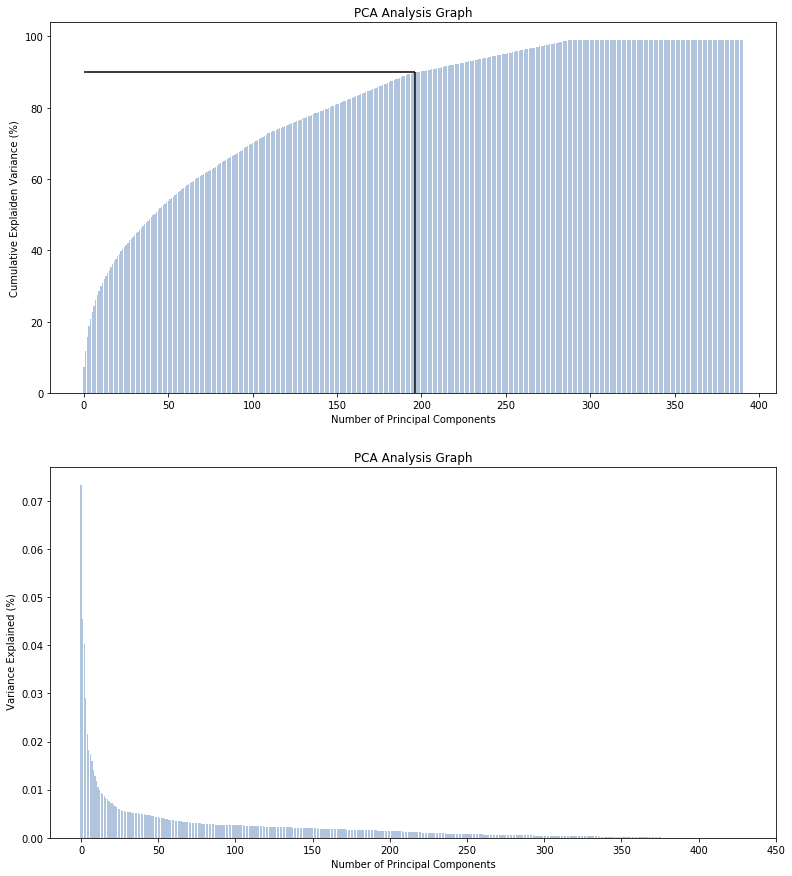

In [90]:
# PCA analysis
from helpers import pca_analysis_plot
pca_analysis_plot(n_conponents=n_components, 
             index= index, 
             var_values = values,
             cum_sum = cumulative_sum_var)

After looking at the variance explained by each component in the screen plots above, I decided to select 196 components, which account for about 90% of the variance explaided. 

In [92]:
# Number of componetes I selected
n_components = 196

# New pca
pca = PCA(n_components)

azdias_pca = pca.fit_transform(azdias_scaled_df)

In [95]:
azdias_pca

array([[ 4.63636306,  5.17334754,  5.953021  , ..., -0.53320171,
        -0.53582339,  0.88109935],
       [-0.79306375,  2.4655554 ,  1.20570043, ..., -0.31355766,
        -1.10362674,  0.42255912],
       [-5.91659418,  1.07952586, -2.72929663, ...,  0.4525781 ,
         0.24184853, -0.11151016],
       ..., 
       [-3.61879654,  0.39060823,  6.2666517 , ..., -0.8776908 ,
        -0.29288028,  1.53620901],
       [ 7.94108704, -4.82484253,  4.31773847, ...,  0.58644573,
         0.46209977,  0.09765655],
       [-0.91126647, -0.22897368, -3.98497033, ..., -0.60841622,
         0.77874277,  0.48078393]])

In [ ]:
# Dump azdias_pca to a pickle object 
#pickle.dump(azdias_pca, open("azdias_pca.pickle", "wb"))

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [93]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [94]:
#mailout_train.head()

In [ ]:
#save_csv(mailout_train, 'data_project', 'Udacity_MAILOUT_052018_TRAIN.csv')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.head()

In [ ]:
#save_csv(mailout_test, 'data_project', 'Udacity_MAILOUT_052018_TEST.csv')

In [ ]:
display(mailout_train.shape )
display(mailout_test.shape)

In [ ]:
mailout_train.CAMEO_INTL_2015.unique()